# LC GcAMP Tone Only Analysis

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import sys
# change pkg_path variable to the directory storing the package
sys.path.insert(0, '../utility_code')
import fp_dat, fp_viz
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sci


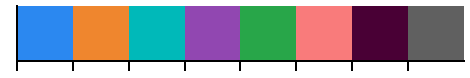

In [18]:
fp_viz.plot_style()
npg_pal=['#2b88f0', '#EF862E', '#00B9B9', '#9147B1', '#28A649', '#F97B7B', '#490035', '#606060']
fp_viz.set_palette(color_pal=['#2b88f0', '#EF862E', '#00B9B9', '#9147B1', '#28A649', '#F97B7B', '#490035', '#606060'], show = True)

## Day 1 Load

In [19]:
df_train_trials = pd.read_csv(
    './data-clean/LC_GcAMP_Tone_Only_Day1.csv')


## Day 2 Load

In [20]:
df_tone_trials = pd.read_csv(
    './data-clean/LC_GcAMP_Tone_Only_Day2.csv')


## Day 3 Load

In [21]:
df_ext_trials = pd.read_csv(
    './data-clean/LC_GcAMP_Tone_Only_Day3.csv')


## Combined across all 3 days

In [22]:
yvar = '465nm_dFF_norm'
xvar = 'time_trial'  
    
# collapse data across all trials
train_mean_vals = df_train_trials.loc[:, ['Animal', 'Trial', xvar, yvar]].groupby([xvar]).mean().reset_index()
# collapse across trials within each animal
train_avg_subj_trial = df_train_trials.loc[:, ['Animal','Trial', xvar, yvar]].groupby(['Animal', xvar]).mean().reset_index()
train_error_vals = train_avg_subj_trial.groupby([xvar]).sem().reset_index()
# grab variables for plotting
train_X = train_mean_vals.loc[:,xvar]
train_Y = train_mean_vals.loc[:,yvar]
train_Yerror = train_error_vals.loc[:,yvar]


In [23]:
# collapse data across all trials
tone_mean_vals = df_tone_trials.loc[:, ['Animal', 'Trial', xvar, yvar]].groupby([xvar]).mean().reset_index()
# collapse across trials within each animal
tone_avg_subj_trial = df_tone_trials.loc[:, ['Animal','Trial', xvar, yvar]].groupby(['Animal', xvar]).mean().reset_index()
tone_error_vals = tone_avg_subj_trial.groupby([xvar]).sem().reset_index()
# grab variables for plotting
tone_X = tone_mean_vals.loc[:,xvar]
tone_Y = tone_mean_vals.loc[:,yvar]
tone_Yerror = tone_error_vals.loc[:,yvar]

In [24]:
# collapse data across all trials
ext_mean_vals = df_ext_trials.loc[:, ['Animal', 'Trial', xvar, yvar]].groupby([xvar]).mean().reset_index()
# collapse across trials within each animal
ext_avg_subj_trial = df_ext_trials.loc[:, ['Animal','Trial', xvar, yvar]].groupby(['Animal', xvar]).mean().reset_index()
ext_error_vals = ext_avg_subj_trial.groupby([xvar]).sem().reset_index()
# grab variables for plotting
ext_X = ext_mean_vals.loc[:,xvar]
ext_Y = ext_mean_vals.loc[:,yvar]
ext_Yerror = ext_error_vals.loc[:,yvar]

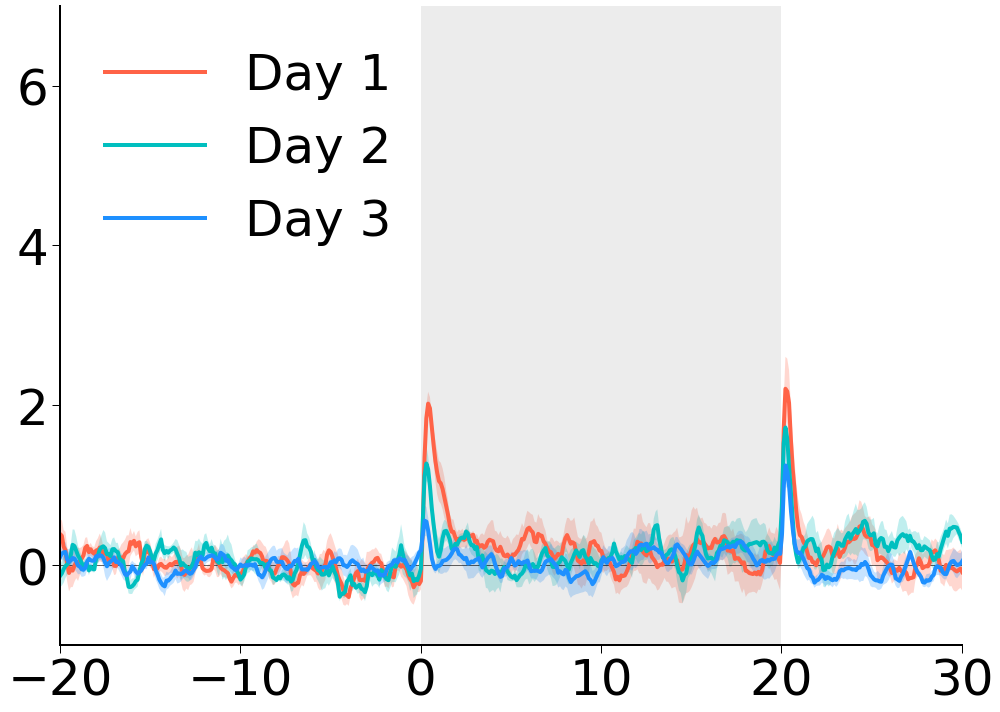

In [25]:
cs_dur = 20
us_del = 40
us_dur = 2

# generate figure and add subplot
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1, 1, 1)
# add dashed line at y=0, dashed lines for shock
ax.axhline(y=0, linestyle='-', color='black', linewidth=0.6, label='_nolegend_')
# add rectangle to highlight CS period
ax.axvspan(0, cs_dur, facecolor='grey', ymin=0, alpha=.15)
# add black dash rectangle to indicate shock
ax.axvspan(us_del, us_del+us_dur, facecolor='none', edgecolor='black', ls='--', ymin=0)

# plot the data
plt.plot(train_X, train_Y, linewidth=4, color = 'tomato')
plt.fill_between(train_X, train_Y-train_Yerror, train_Y+train_Yerror, alpha=0.25, facecolor = 'tomato')
# adjust x-axis margin to shift plot adjacent to y-axis
ax.margins(x=0)

# plot the data
plt.plot(tone_X, tone_Y, linewidth=4, color = 'c')
plt.fill_between(tone_X, tone_Y-tone_Yerror, tone_Y+tone_Yerror, alpha=0.25, facecolor = 'c')
# adjust x-axis margin to shift plot adjacent to y-axis
ax.margins(x=0)

# plot the data
plt.plot(ext_X, ext_Y, linewidth=4, color = 'dodgerblue')
plt.fill_between(ext_X, ext_Y-ext_Yerror, ext_Y+ext_Yerror, alpha=0.25, facecolor = 'dodgerblue')
# adjust x-axis margin to shift plot adjacent to y-axis
ax.margins(x=0)


plt.ylim(-1, 6.99)
plt.xlim(-20,30)

ax.tick_params(labelsize= 50, width=1, length=8)
ax.set_ylabel('')
ax.set_xlabel('')

plt.legend(['Day 1', 'Day 2', 'Day 3'], loc = 2, prop={'size': 50})
plt.tight_layout()

plt.savefig('/Users/jake/Library/CloudStorage/Box-Box/WiltgenLab/Experiments/jake/LC Paper Clean Data and Analyses/LC_GCaMP_Tone_Only/figs/LC_GCaMP_Tone_Only_Traces')


In [26]:
# Get the peak dFF to the tone onset in the tone only group on each day

tone_d1_prepost = fp_dat.calc_pre_post(
    df_train_trials, event='tone', t_pre=(-2, 0), t_post=(0, 2), measure='max')
tone_d2_prepost = fp_dat.calc_pre_post(
    df_tone_trials, event='tone',  t_pre=(-2, 0), t_post=(0, 2), measure='max')
tone_d3_prepost = fp_dat.calc_pre_post(
    df_ext_trials, event='tone',  t_pre=(-2, 0), t_post=(0, 2), measure='max')

tone_d1_prepost['Day'] = '1'
tone_d2_prepost['Day'] = '2'
tone_d3_prepost['Day'] = '3'

# combine all days data from tone only into one dataframe
tone_only_prepost = pd.concat(
    [tone_d1_prepost, tone_d2_prepost, tone_d3_prepost]).reset_index(drop=True)

tone_only_post = tone_only_prepost.query("epoch == 'post-tone'")


In [27]:
import pingouin as pg

In [28]:
# Run mixed RM ANOVA with day as within subjects factor and group as between subjects
# to determine whether there is an effect of day, group, or interaction on tone response dFF
pg.rm_anova(data = tone_only_post, dv = '465nm_dFF_norm', within = 'Day', subject='Animal').round(3)

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,Day,2,8,18.259,0.001,0.82,0.937


## Tone Termination

In [29]:
# Get the peak dFF to the tone onset in the tone only group on each day

termination_d1_prepost = fp_dat.calc_pre_post(
    df_train_trials, event='tone', t_pre=(18, 20), t_post=(20, 22), measure='max')
termination_d2_prepost = fp_dat.calc_pre_post(
    df_tone_trials, event='tone',  t_pre=(18, 20), t_post=(20, 22), measure='max')
termination_d3_prepost = fp_dat.calc_pre_post(
    df_ext_trials, event='tone',  t_pre=(18, 20), t_post=(20, 22), measure='max')

termination_d1_prepost['Day'] = '1'
termination_d2_prepost['Day'] = '2'
termination_d3_prepost['Day'] = '3'

# combine all days data from tone only into one dataframe
termination_prepost = pd.concat(
    [termination_d1_prepost, termination_d2_prepost, termination_d3_prepost]).reset_index(drop=True)

termination_post = termination_prepost.query("epoch == 'post-tone'")


In [30]:
# Run mixed RM ANOVA with day as within subjects factor and group as between subjects
# to determine whether there is an effect of day, group, or interaction on tone response dFF
pg.rm_anova(data = termination_post, dv = '465nm_dFF_norm', within = 'Day', subject='Animal').round(3)

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,Day,2,8,3.362,0.087,0.457,0.706
